In [1]:
import os
os.makedirs('/tmp/spark-events', exist_ok=True)

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Stop any existing context
try:
    SparkContext.getOrCreate().stop()
except:
    pass

# Now create a new session
spark = SparkSession.builder.appName("LogisticRegression").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/27 01:19:02 WARN Utils: Your hostname, datnd-Nitro-AN515-57, resolves to a loopback address: 127.0.1.1; using 192.168.101.128 instead (on interface wlp0s20f3)
25/12/27 01:19:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/27 01:19:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
df_train = spark.read.csv("/home/datnd/Projects/spark-kaggle/data/train.csv", header=True, inferSchema=True)

target_col = "accident_risk_level"

def add_features(df):
    return (
        df
        .withColumn("is_night", (F.col("lighting") == "night").cast("int"))
        .withColumn("bad_weather", (F.col("weather").isin("foggy", "rainy")).cast("int"))
        .withColumn("high_curvature", (F.col("curvature") >= 0.5).cast("int"))
        .withColumn("high_speed", (F.col("speed_limit") >= 60).cast("int"))
        .withColumn("night_high_curvature", (F.col("is_night") * F.col("high_curvature")).cast("int"))
        .withColumn("night_high_speed", (F.col("is_night") * F.col("high_speed")).cast("int"))
        .withColumn("high_curvature_bad_weather", (F.col("high_curvature") * F.col("bad_weather")).cast("int"))
        .withColumn("curvature_x_night", F.col("curvature") * F.col("is_night"))
        .withColumn("speed_x_night", F.col("speed_limit") * F.col("is_night"))
        .withColumn("road_signs_present_i", F.col("road_signs_present").cast("int"))
        .withColumn("public_road_i", F.col("public_road").cast("int"))
        .withColumn("holiday_i", F.col("holiday").cast("int"))
        .withColumn("school_season_i", F.col("school_season").cast("int"))
    )

# split
train_df, test_df = df_train.randomSplit([0.8, 0.2], seed=42)
train_fe = add_features(train_df)
test_fe  = add_features(test_df)

categorical_cols = ["road_type", "lighting", "weather", "time_of_day"]

numeric_cols = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents"]
interaction_numeric_cols = ["curvature_x_night", "speed_x_night"]
numeric_to_scale = numeric_cols + interaction_numeric_cols

boolean_features = [
    "is_night", "bad_weather", "high_curvature", "high_speed",
    "night_high_curvature", "night_high_speed", "high_curvature_bad_weather",
    "road_signs_present_i", "public_road_i", "holiday_i", "school_season_i"
]

label_indexer = StringIndexer(inputCol=target_col, outputCol="label", handleInvalid="keep")
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe", dropLast=True) for c in categorical_cols]

num_assembler = VectorAssembler(inputCols=numeric_to_scale, outputCol="num_raw", handleInvalid="keep")

scaler = StandardScaler(inputCol="num_raw", outputCol="num_scaled", withMean=False, withStd=True)

bool_assembler = VectorAssembler(inputCols=boolean_features, outputCol="bool_features", handleInvalid="keep")

final_assembler = VectorAssembler(
    inputCols=["num_scaled", "bool_features"] + [f"{c}_ohe" for c in categorical_cols],
    outputCol="features",
    handleInvalid="keep"
)

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    family="multinomial",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0
)

pipeline = Pipeline(stages=[
    label_indexer,
    *indexers, *encoders,
    num_assembler, scaler,
    bool_assembler,
    final_assembler,
    lr
])

model = pipeline.fit(train_fe)
train = model.transform(train_fe)
pred = model.transform(test_fe)

25/12/27 01:19:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [7]:
import pandas as pd

# Tính toán các chỉ số cho Train
metrics_train = {
    "Accuracy": evaluator_acc.evaluate(train),
    "Precision": evaluator_precision.evaluate(train),
    "Recall": evaluator_recall.evaluate(train),
    "F1-Score": evaluator_f1.evaluate(train)
}

# Tính toán các chỉ số cho Test
metrics_test = {
    "Accuracy": evaluator_acc.evaluate(pred),
    "Precision": evaluator_precision.evaluate(pred),
    "Recall": evaluator_recall.evaluate(pred),
    "F1-Score": evaluator_f1.evaluate(pred)
}

summary_df = pd.DataFrame([metrics_train, metrics_test], index=["Train Set", "Test Set"]).T

print("=== BÁO CÁO HIỆU SUẤT MÔ HÌNH ===")
print(summary_df.round(4))

=== BÁO CÁO HIỆU SUẤT MÔ HÌNH ===
           Train Set  Test Set
Accuracy      0.7883    0.7880
Precision     0.8030    0.8027
Recall        0.7883    0.7880
F1-Score      0.7923    0.7919


In [10]:
from sklearn.metrics import classification_report


results_pd = pred.select("label", "prediction").toPandas()

labels = model.stages[0].labels 

print("=== CHI TIẾT HIỆU SUẤT TỪNG LỚP ===")
print(classification_report(results_pd['label'], results_pd['prediction'], target_names=labels))

=== CHI TIẾT HIỆU SUẤT TỪNG LỚP ===
              precision    recall  f1-score   support

         low       0.88      0.78      0.83     34747
        high       0.87      0.80      0.84     34450
      medium       0.65      0.78      0.71     34027

    accuracy                           0.79    103224
   macro avg       0.80      0.79      0.79    103224
weighted avg       0.80      0.79      0.79    103224



/tmp/ipykernel_59105/2529242097.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10), palette='viridis')


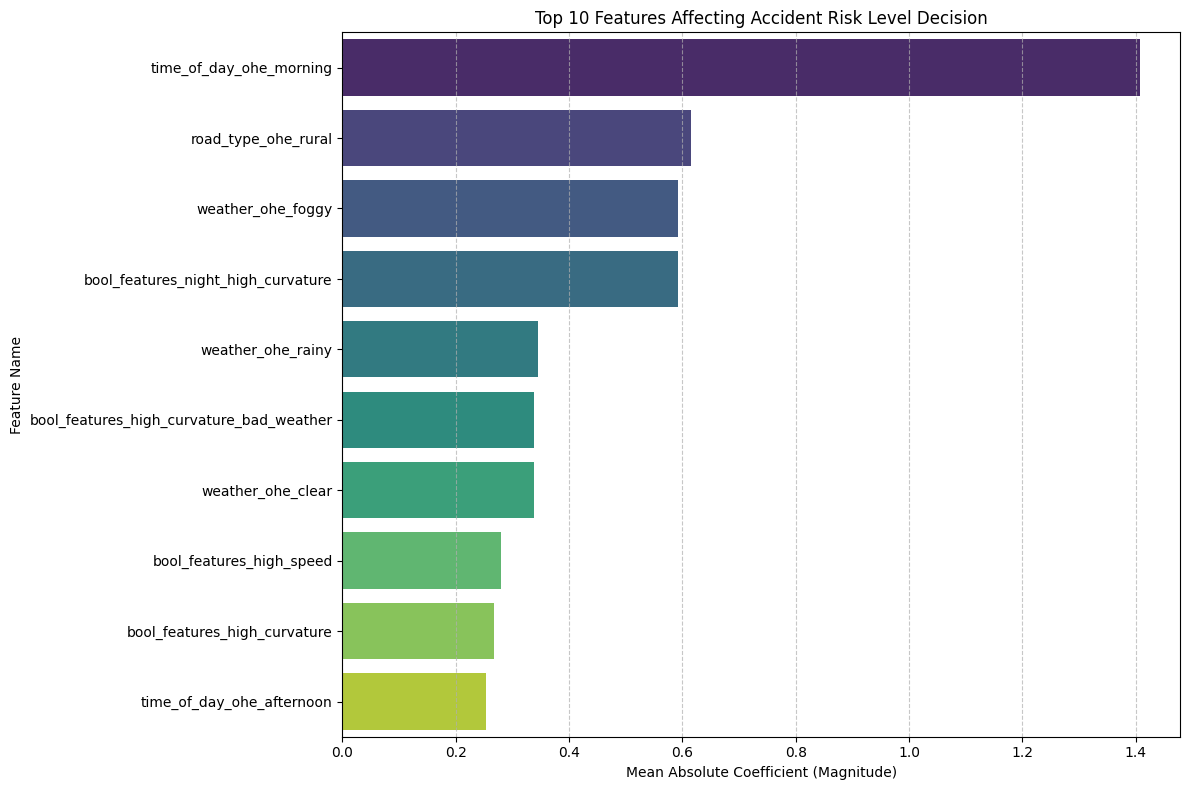

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Trích xuất tên các feature từ VectorAssembler cuối cùng
model_lr = model.stages[-1]
final_assembler_stage = model.stages[-2]

# Lấy metadata để biết tên chính xác của từng cột sau khi OHE
attrs = train.schema["features"].metadata["ml_attr"]["attrs"]
feature_names = []
for attr_type in attrs:
    for attr in attrs[attr_type]:
        feature_names.append(attr["name"])

# 2. Lấy Coefficients (Hệ số) từ Logistic Regression
# Với multinomial, coefficients là một Matrix (num_classes x num_features)
coefficients = model_lr.coefficientMatrix.toArray()

# Tính giá trị tuyệt đối trung bình của hệ số cho mỗi feature để đánh giá tầm quan trọng
# (Càng xa 0 càng có ảnh hưởng mạnh đến việc phân loại)
importance = np.mean(np.abs(coefficients), axis=0)

# 3. Tạo DataFrame để dễ dàng vẽ biểu đồ
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 4. Trực quan hóa
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10), palette='viridis')
plt.title('Top 10 Features Affecting Accident Risk Level Decision')
plt.xlabel('Mean Absolute Coefficient (Magnitude)')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
# Đường dẫn lưu mô hình
model_path = "/home/datnd/Projects/spark-kaggle/traffic_lr_model"

# Lưu mô hình
model.write().overwrite().save(model_path)

print(f"Mô hình đã được lưu tại: {model_path}")

Mô hình đã được lưu tại: /home/datnd/Projects/spark-kaggle/traffic_lr_model
